In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pip install keras-cv
#!pip install timm

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
import os

In [4]:
#seeds
np.random.seed(42)

In [5]:
#definitions
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 15
EPOCHS = 50
data_dir = '/kaggle/input/data'

In [6]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [7]:
train_classes = sorted(os.listdir(train_dir))
val_classes = sorted(os.listdir(val_dir))
test_classes = sorted(os.listdir(test_dir))

In [8]:
assert train_classes == val_classes == test_classes, "Class folders don't match across train/val/test"
print("Found classes:", train_classes)
print(f"Number of classes: {len(train_classes)}")

Found classes: ['aphid', 'black_rust', 'blast', 'brown_rust', 'common_root_rot', 'fusarium_head_blight', 'healthy', 'leaf_blight', 'mildew', 'mite', 'septoria', 'smut', 'stem_fly', 'tan_spot', 'yellow_rust']
Number of classes: 15


In [9]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Pre-trained mean/std
])

train_dataset = datasets.ImageFolder(train_dir, transform=data_augmentation)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [10]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=True)  # ViT Tiny model
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)  # Replace final layer

    def forward(self, x):
        return self.vit(x)

model = ViTModel(num_classes=NUM_CLASSES)
model = model.cuda() if torch.cuda.is_available() else model

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=1e-6)

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 50 == 0:
            train_acc = 100 * correct / total
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i}/{len(train_loader)}], Loss: {running_loss/i:.4f}, Train Accuracy: {train_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda() if torch.cuda.is_available() else (inputs, labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * val_correct / val_total
    print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.2f}%")

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(100 * correct / total)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_model.pth')
    scheduler.step(val_loss)

print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

Epoch [1/50], Batch [50/410], Loss: 3.3203, Train Accuracy: 10.69%
Epoch [1/50], Batch [100/410], Loss: 2.9388, Train Accuracy: 14.47%
Epoch [1/50], Batch [150/410], Loss: 2.7627, Train Accuracy: 17.88%
Epoch [1/50], Batch [200/410], Loss: 2.6204, Train Accuracy: 21.30%
Epoch [1/50], Batch [250/410], Loss: 2.5284, Train Accuracy: 23.74%
Epoch [1/50], Batch [300/410], Loss: 2.4305, Train Accuracy: 26.39%
Epoch [1/50], Batch [350/410], Loss: 2.3505, Train Accuracy: 28.54%
Epoch [1/50], Batch [400/410], Loss: 2.2887, Train Accuracy: 30.13%
Epoch [1/50], Validation Loss: 2.1194, Validation Accuracy: 29.00%
Epoch [2/50], Batch [50/410], Loss: 1.6791, Train Accuracy: 46.06%
Epoch [2/50], Batch [100/410], Loss: 1.6493, Train Accuracy: 47.69%
Epoch [2/50], Batch [150/410], Loss: 1.6496, Train Accuracy: 47.33%
Epoch [2/50], Batch [200/410], Loss: 1.6398, Train Accuracy: 48.08%
Epoch [2/50], Batch [250/410], Loss: 1.6279, Train Accuracy: 48.44%
Epoch [2/50], Batch [300/410], Loss: 1.6114, Train 

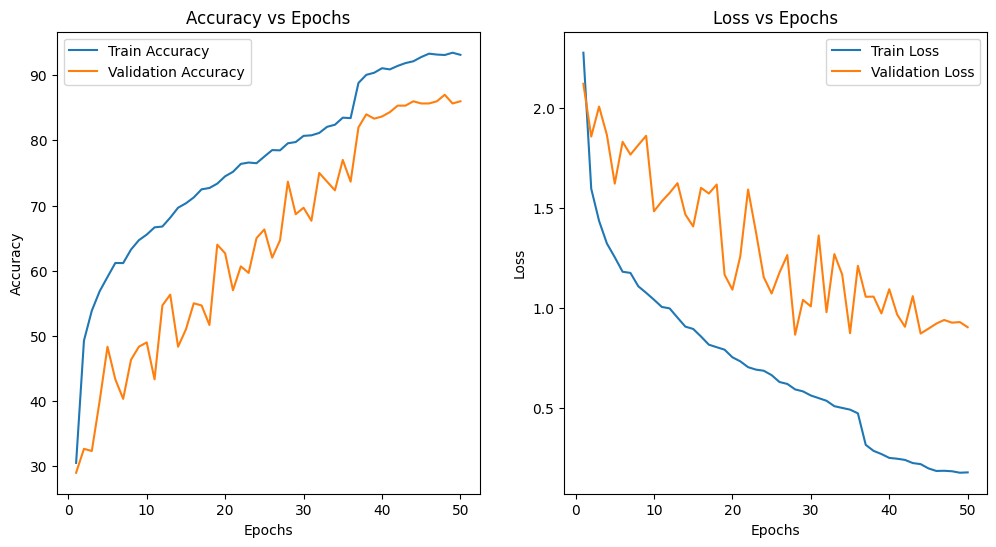

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Classification Report:
                      precision    recall  f1-score   support

               aphid       0.83      1.00      0.91        20
          black_rust       0.83      0.75      0.79        20
               blast       0.83      1.00      0.91        20
          brown_rust       0.83      0.95      0.88        20
     common_root_rot       1.00      0.95      0.97        20
fusarium_head_blight       1.00      0.80      0.89        20
             healthy       1.00      0.15      0.26        20
         leaf_blight       0.89      0.80      0.84        20
              mildew       0.94      0.80      0.86        20
                mite       1.00      0.80      0.89        20
            septoria       1.00      1.00      1.00        20
                smut       1.00      1.00      1.00        20
            stem_fly       1.00      1.00      1.00        20
            tan_spot       0.75      0.90      0.82        20
         yellow_rust       0.53      1.00    

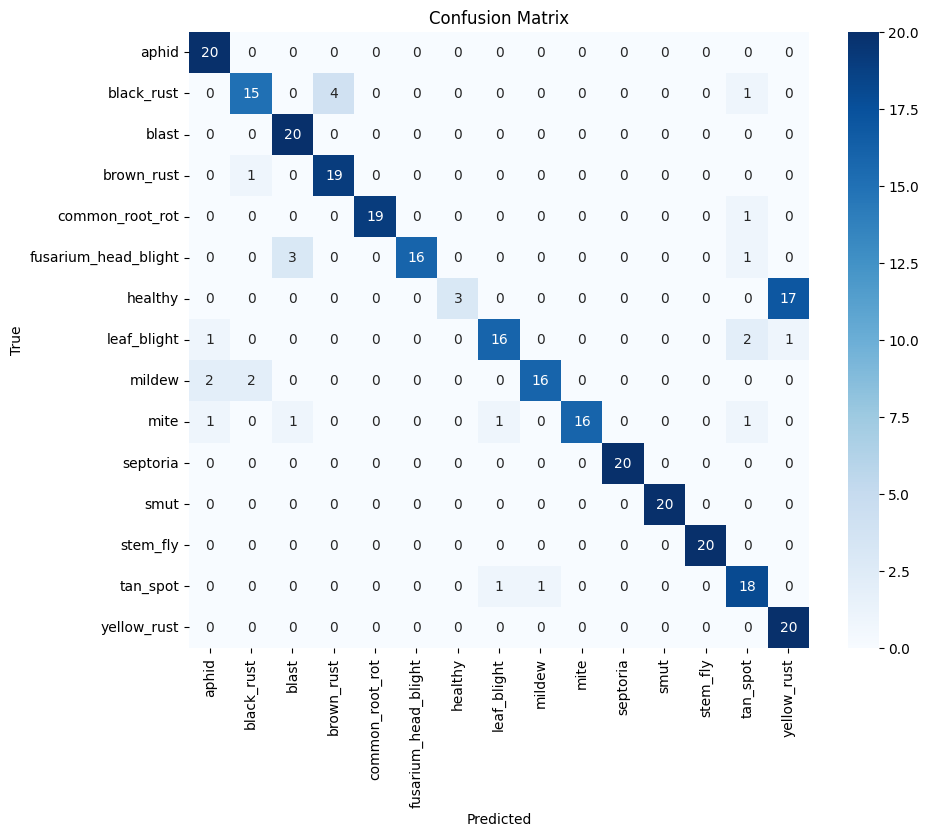

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "vit87onval.pth")
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/vit87onval.pth


In [ ]:
model = ViTModel(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load('best_vit_model.pth'))
model = model.cuda() if torch.cuda.is_available() else model
#model.eval()

<ipython-input-21-9fad971cc847>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load trained weights


Test Accuracy: 82.40%

Classification Report:
                      precision    recall  f1-score   support

               aphid       0.81      1.00      0.89        50
          black_rust       0.85      0.58      0.69        50
               blast       0.85      1.00      0.92        50
          brown_rust       0.70      0.92      0.79        50
     common_root_rot       0.87      0.92      0.89        50
fusarium_head_blight       1.00      0.80      0.89        50
             healthy       1.00      0.10      0.18        50
         leaf_blight       0.91      0.78      0.84        50
              mildew       0.98      0.82      0.89        50
                mite       0.88      0.74      0.80        50
            septoria       0.98      0.96      0.97        50
                smut       0.98      1.00      0.99        50
            stem_fly       0.98      0.96      0.97        50
            tan_spot       0.68      0.78      0.73        50
         yellow_rust   

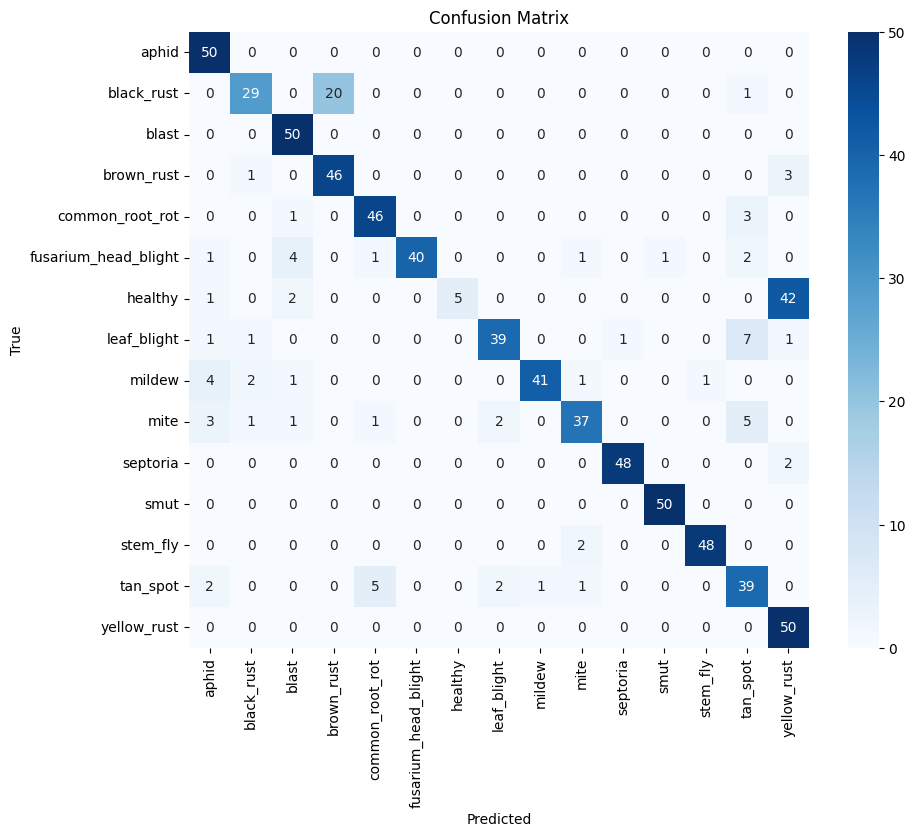

In [21]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

model_path = "vit87onval.pth"
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()